# Imports


In [143]:
import numpy  as np
import pandas as pd
import scikitplot as skplt
import pickle
import inflection
import seaborn as sns
import math
import gzip

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn  import preprocessing   as pp
from sklearn  import linear_model    as lm
from sklearn  import model_selection as ms
from sklearn  import ensemble        as en
from sklearn  import neighbors       as nh
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer



## 0.0 Helper Functions

In [144]:
def precision_at_k( data, perc) :

    k=int(np.floor(len(data)*perc))

    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'])

def recall_at_k( data, perc ):

    k=int(np.floor(len(data)*perc))
    
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'])

def metrics(model_name,precision_at_k,recall_at_k,roc_auc):

    return pd.DataFrame({'Model Name': model_name,
                        'Precision_at_k': precision_at_k,
                        'Recall_at_k': recall_at_k,
                        'Roc_auc': roc_auc}, index=[0])

## 0.1 Loading Dataset


In [145]:
df_raw = pd.read_csv('data/train.csv')

In [146]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [147]:
df1 = df_raw.copy()

# 1.0 Data Description

## 1.1 Rename Columns

In [148]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.1.1 Split data in train and test

In [149]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [150]:
X_ini = df1.drop(['response'], axis = 1)
y_ini = df1['response'].copy()

x_df1, x_test, y_df1, y_test = ms.train_test_split(X_ini,y_ini,test_size=0.1)

df1 = pd.concat([x_df1, y_df1], axis = 1)

## 1.2 Data Dimension


In [151]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 342998
Number of Columns: 12


## 1.3 Data Types

In [152]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [153]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Data Descriptive

In [154]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [155]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190562.288419,190548.5,110041.835421,-0.000052,-1.201043
1,age,20.0,85.0,65.0,38.822256,36.0,15.507278,0.671284,-0.567532
2,driving_license,0.0,1.0,1.0,0.997878,1.0,0.046021,-21.636943,466.160039
3,region_code,0.0,52.0,52.0,26.390737,28.0,13.239867,-0.114782,-0.870809
4,previously_insured,0.0,1.0,1.0,0.458417,0.0,0.498268,0.166912,-1.972152
5,annual_premium,2630.0,540165.0,537535.0,30562.952947,31667.0,17218.875853,1.758881,33.500693
6,policy_sales_channel,1.0,163.0,162.0,112.069735,135.0,54.186282,-0.901449,-0.967826
7,vintage,10.0,299.0,289.0,154.365060,154.0,83.674274,0.001574,-1.201794
8,response,0.0,1.0,1.0,0.122470,0.0,0.327828,2.303230,3.304886


# 2.0 Feature Engineering

In [156]:
df2 = df1.copy()

In [157]:
#vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

#vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0 )

# 3.0 Data Filtering

In [158]:
df3 = df2.copy()

# 4.0 EDA

In [159]:
df4 = df3.copy()

## 4.1 Análise Univariada

In [160]:
df4['response'].value_counts()

response
0    300991
1     42007
Name: count, dtype: int64

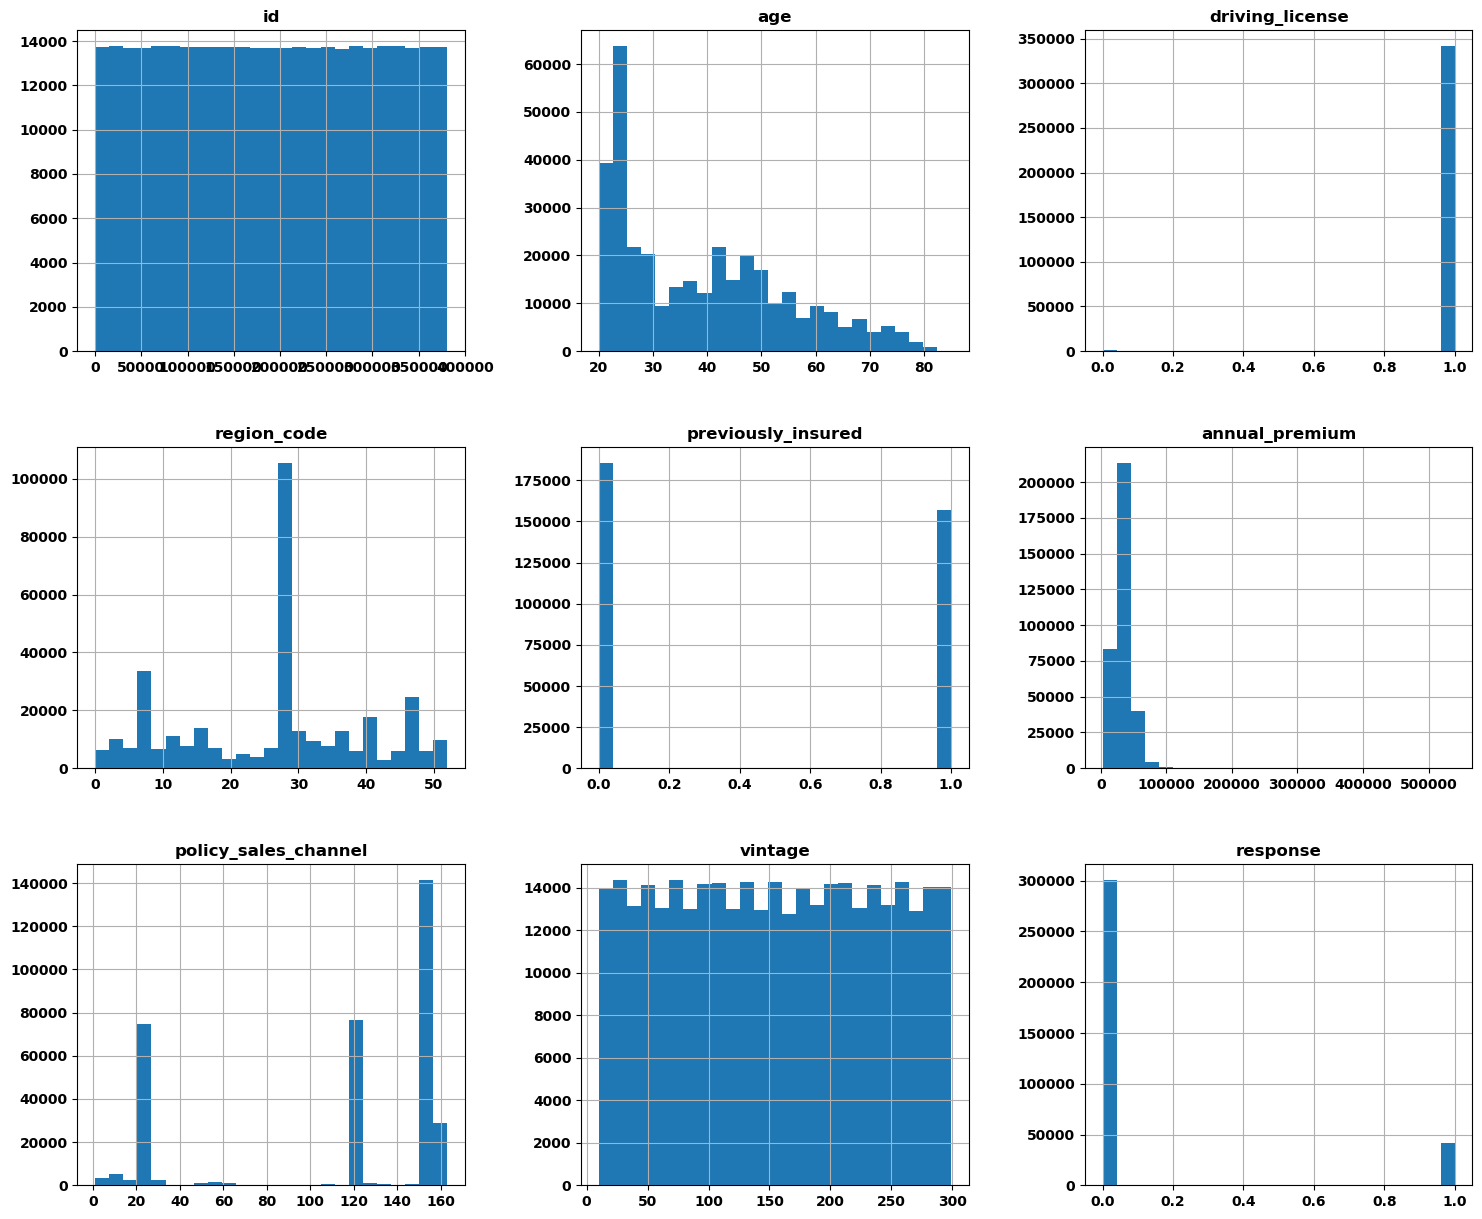

In [161]:
num_attributes.hist(bins=25, figsize=(18, 15));

<Axes: xlabel='response', ylabel='age'>

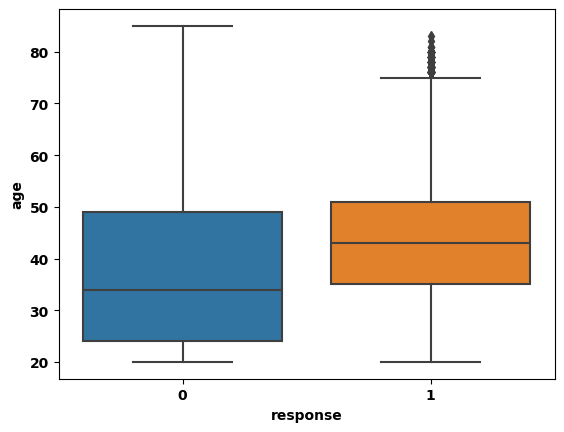

In [162]:
#age
sns.boxplot(x='response', y='age',data=df4)

### 4.1.2. Anual Income

<Axes: xlabel='response', ylabel='annual_premium'>

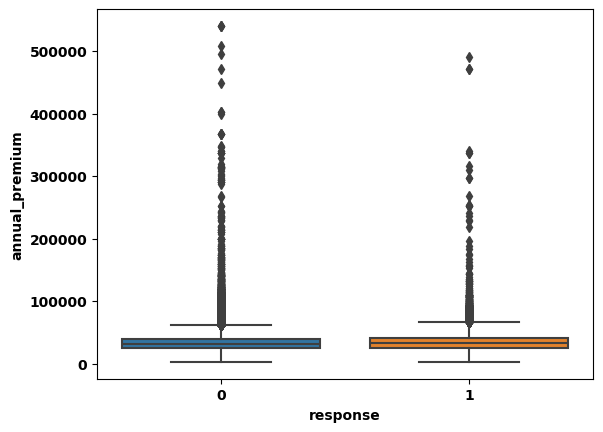

In [163]:
sns.boxplot( x='response', y='annual_premium', data=df4 )

In [164]:
df4 = df4[(df4['annual_premium'] > 10000) &(df4['annual_premium'] < 100000)]

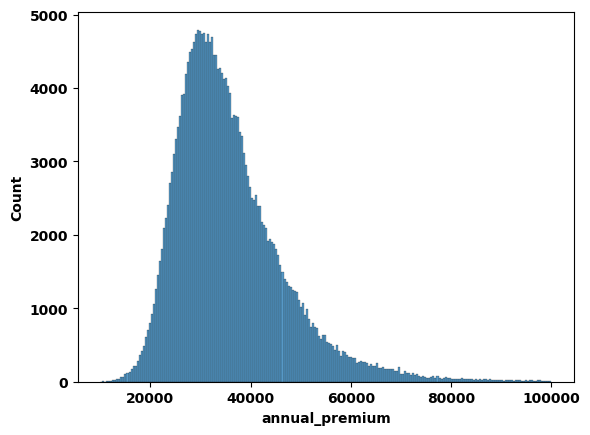

In [165]:
aux00 = df4.loc[df4['response'] == 0, 'annual_premium']
sns.histplot( aux00 );

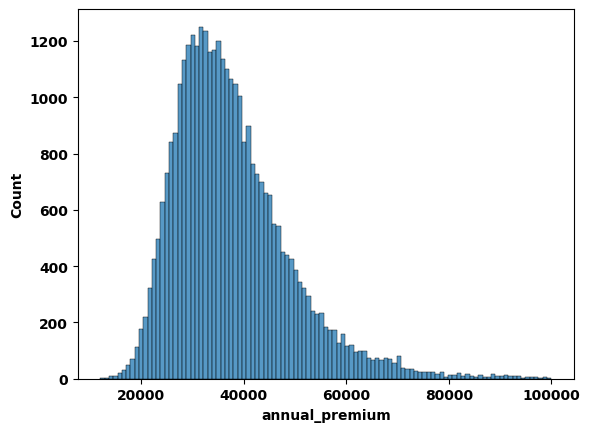

In [166]:
aux00 = df4.loc[df4['response'] == 1, 'annual_premium']
sns.histplot( aux00 );

### 4.1.3. Driving License

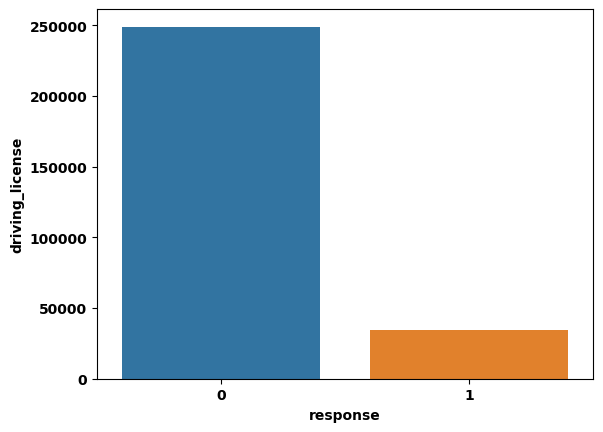

In [167]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.4. Region Code

<Axes: xlabel='region_code', ylabel='id'>

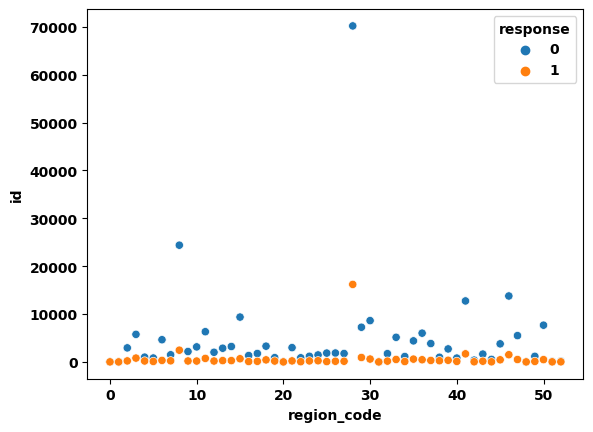

In [168]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

### 4.1.5. Previously Insured

<Axes: xlabel='previously_insured', ylabel='id'>

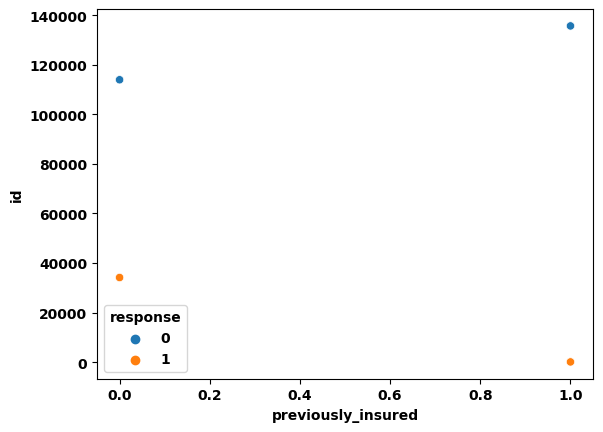

In [169]:
aux0 = df4[['id', 'previously_insured', 'response']].groupby( ['previously_insured', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='previously_insured', y='id', hue='response', data=aux0 )

In [170]:
pd.crosstab(df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.769372,0.230628
1,0.999234,0.000766


### 4.1.6. Vehicle Age

In [171]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,124057
1,below_1_year,1,5372
2,between_1_2_year,0,117327
3,between_1_2_year,1,25233
4,over_2_years,0,8230
5,over_2_years,1,3656


### 4.1.7. Vehicle Damage

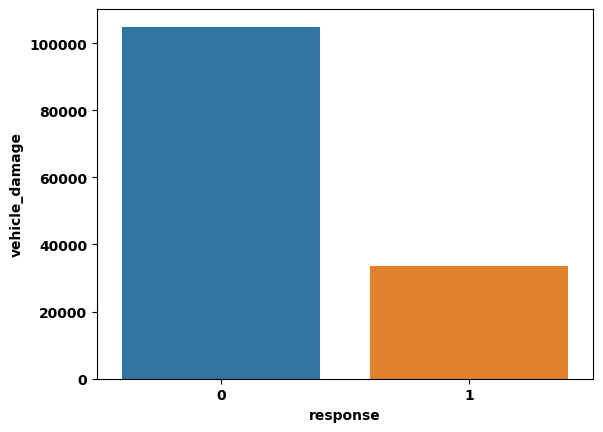

In [172]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.8. Policy Sales Channel - Stacked Percentage Bar

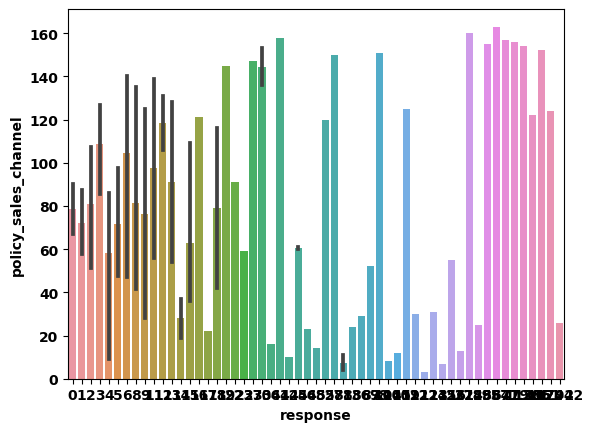

In [173]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

### 4.1.9. Vintage

<Axes: xlabel='vintage', ylabel='Count'>

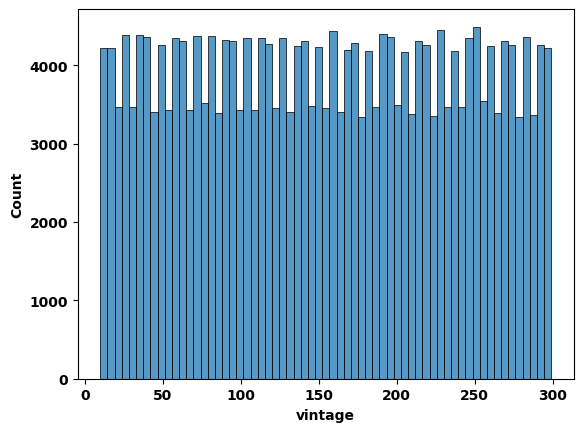

In [174]:
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux )

# 5.0. Data Preparation

In [175]:
df5 = df4.copy()

## 5.0.1 Split train and validation

In [176]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [177]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )
pickle.dump( ss, open( 'src/features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [178]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
pickle.dump( mms_age, open( 'src/features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )
pickle.dump( mms_vintage, open( 'src/features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [179]:
# gender - One Hot Encoding / Target Encoding
df5 = pd.get_dummies( df5, prefix='gender', columns=['gender'],dtype=int)

# region_code - Target Encoding / Frequency Encoding

target_encode_region_code = df5.groupby('region_code').size() / len(df5)
df5['region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump( target_encode_region_code, open( 'src/features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'],dtype=int)

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
pickle.dump( fe_policy_sales_channel, open( 'src/features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

## 5.4. Validation Preparation

In [180]:
# gender
x_validation = pd.get_dummies( x_validation, prefix='gender', columns=['gender'],dtype=int )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'],dtype=int )

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform( x_validation[['annual_premium']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.transform( x_validation[['vintage']].values )

# fillna
x_validation = x_validation.fillna( 0 )

## 5.5 Train Preparation

In [181]:
x_train = df5.drop('response', axis =1)
y_train = df5['response']

# 6.0. Feature Selection

## 6.1. Feature Importance

In [182]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = x_train.drop('id', axis=1)
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                annual_premium    0.276262
0                       vintage    0.252283
0                           age    0.170097
0                   region_code    0.084839
0                vehicle_damage    0.068971
0          policy_sales_channel    0.060593
0            previously_insured    0.058796
0      vehicle_age_below_1_year    0.014977
0  vehicle_age_between_1_2_year    0.007169
0      vehicle_age_over_2_years    0.003471
0                 gender_Female    0.001033
0                   gender_Male    0.000968
0               driving_license    0.000540


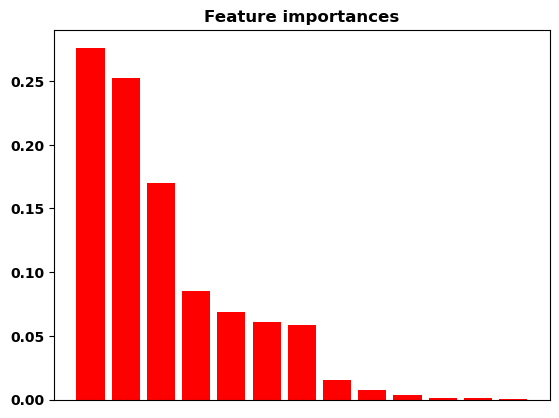

In [183]:
importances = forest.feature_importances_


# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, importances):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 ).sort_values( 'importance', ascending=False )
    
print( df )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(x= df['feature'], height=df['importance'],data=df,color="r")
plt.xticks([])
plt.show()

# 7.0. Machine Learning

In [184]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = x_train[ cols_selected ]
x_val = x_validation[ cols_selected ]
y_val = y_validation.copy()

## 7.1. KNN Classifier

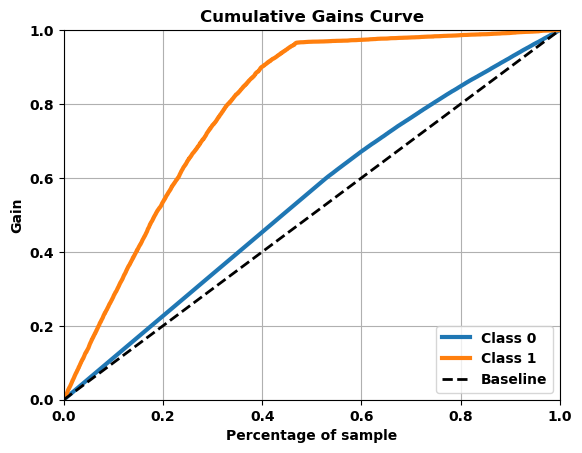

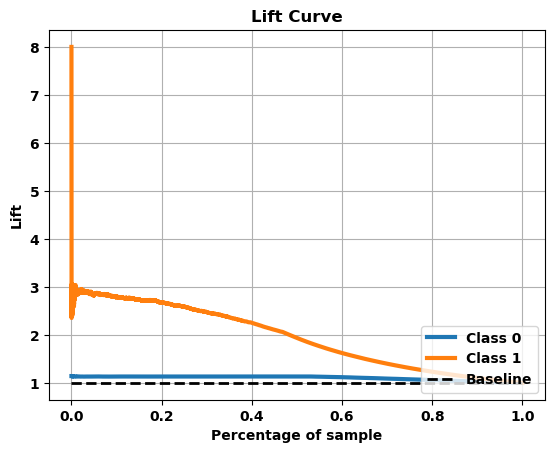

In [185]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=15)

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_knn );

## 7.2. Logistic Regression

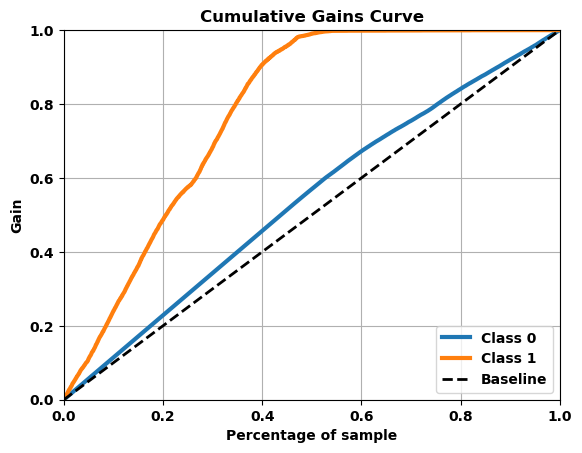

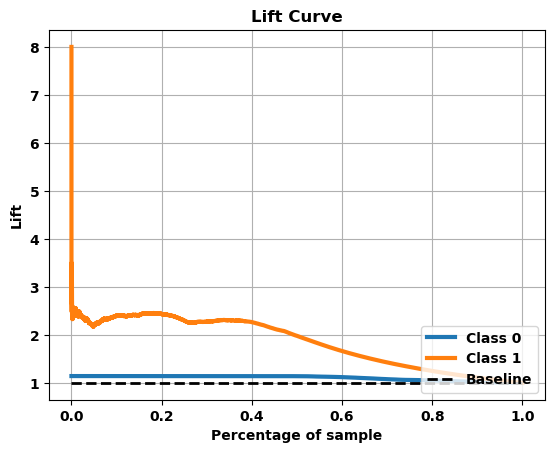

In [186]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3. Extra Trees Classifier



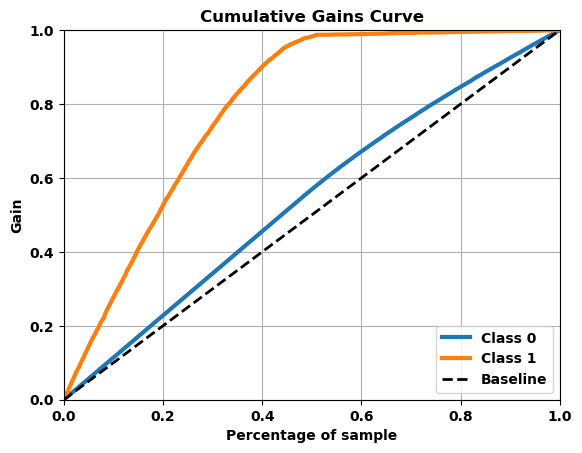

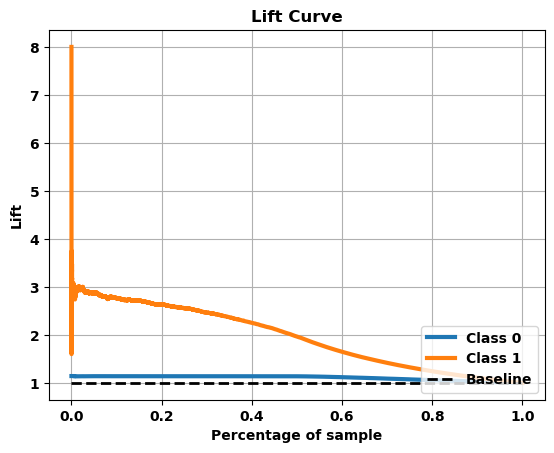

In [187]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=100, n_jobs=-1, random_state=42 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_et );

## 7.4. Random Forest

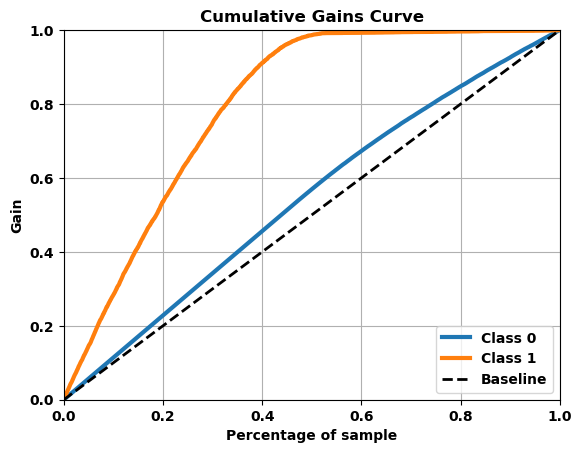

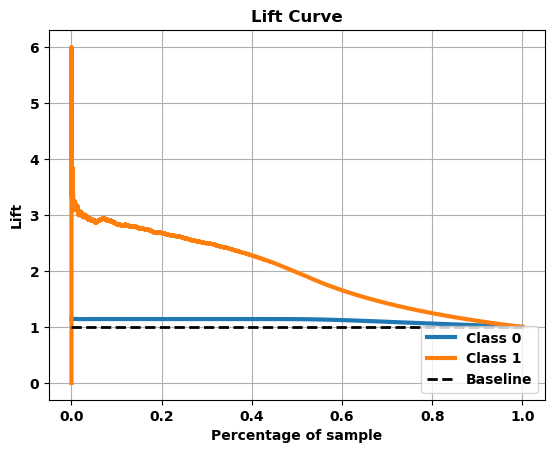

In [188]:
# model definition
rf = en.RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 ) 

# model training
rf.fit( x_train, y_train )

# model prediction
yhat_rf = rf.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_rf );

## 7.5 Light Gradient Boosting Machine Classifier model

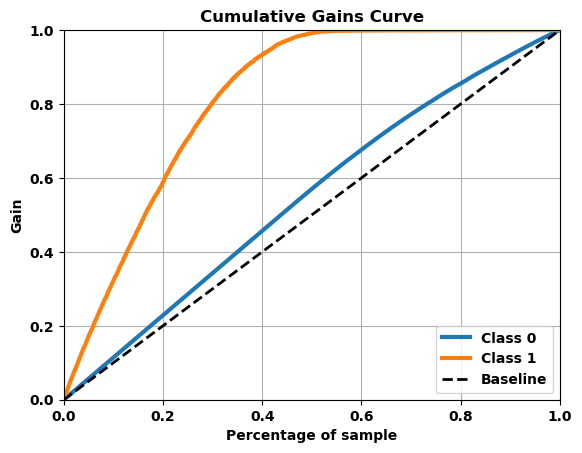

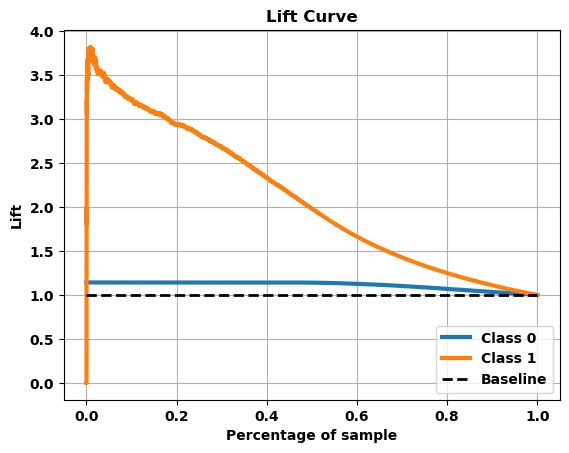

In [189]:
# model definition
lgbm_model = LGBMClassifier(verbose=0)

# model training
lgbm_model.fit( x_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lgbm );

# 7.6 Model Performance Metrics

### 7.6.1 KNN Performance

In [190]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_val.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_knn = precision_at_k(df8,0.2)
print('precision_at_k: {}'.format(precision_at_knn))

# compute recall at k
recall_at_knn = recall_at_k(df8,0.2)
print('recall_at_k: {}'.format(recall_at_knn))

roc_auc_knn = roc_auc_score(y_val, yhat_knn[:,1])
print('ROC AUC Score: {}'.format(roc_auc_knn))

aux1 = metrics('KNN Classifier', precision_at_knn,recall_at_knn,roc_auc_knn)
aux1

precision_at_k: 0.3337442761535752
recall_at_k: 0.5339532262609186
ROC AUC Score: 0.829670804702974


,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,KNN Classifier,0.333744,0.533953,0.829671


### 7.6.2 Logistic Regression Performance

In [191]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_val.copy()

# propensity score
df8['score'] = yhat_lr[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_lr = precision_at_k(df8, 0.2)
print('precision_at_k: {}'.format(precision_at_lr))

# compute recall at k
recall_at_lr = recall_at_k(df8, 0.2)
print('recall_at_k: {}'.format(recall_at_lr))

roc_auc_lr = roc_auc_score(y_val, yhat_lr[:,1])
print('ROC AUC Score: {}'.format(roc_auc_lr))

aux2 = metrics('Logistic Regression', precision_at_lr,recall_at_lr,roc_auc_lr)
aux2

precision_at_k: 0.3039802747446284
recall_at_k: 0.48633417864187095
ROC AUC Score: 0.8216030218496922


,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,Logistic Regression,0.30398,0.486334,0.821603


### 7.6.3 Extra Tree Performance

In [192]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_val.copy()

# propensity score
df8['score'] = yhat_et[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_et = precision_at_k(df8, 0.2)
print('precision_at_2000: {}'.format(precision_at_et))

# compute recall at k
recall_at_et = recall_at_k(df8, 0.2)
print('recall_at_2000: {}'.format(recall_at_et))

roc_auc_et = roc_auc_score(y_val, yhat_et[:,1])
print('ROC AUC Score: {}'.format(roc_auc_et))

aux3 = metrics('Extra Tree', precision_at_et,recall_at_et,roc_auc_et)
aux3

precision_at_2000: 0.32916519901373725
recall_at_2000: 0.5266272189349113
ROC AUC Score: 0.8344902746297294


,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,Extra Tree,0.329165,0.526627,0.83449


### 7.6.4 Random Forest Performance

In [193]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_val.copy()

# propensity score
df8['score'] = yhat_rf[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_rf = precision_at_k(df8, 0.2)
print('precision_at_k: {}'.format(precision_at_rf))

# compute recall at k
recall_at_rf = recall_at_k(df8, 0.2)
print('recall_at_k: {}'.format(recall_at_rf))

roc_auc_rf = roc_auc_score(y_val, yhat_rf[:,1])
print('ROC AUC Score: {}'.format(roc_auc_rf))

aux4 = metrics('Random Forest', precision_at_rf,recall_at_rf,roc_auc_rf)
aux4

precision_at_k: 0.33524128214159915
recall_at_k: 0.5363482671174978
ROC AUC Score: 0.839927210421759


,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,Random Forest,0.335241,0.536348,0.839927


### 7.6.5 LGBM Performance

In [194]:
# copy dataframe
df8 = x_val.copy()
df8['response'] = y_val.copy()

# propensity score
df8['score'] = yhat_lgbm[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_lgbm = precision_at_k(df8, 0.2)
print('precision_at_k: {}'.format(precision_at_lgbm))

# compute recall at k
recall_at_lgbm = recall_at_k(df8, 0.2)
print('recall_at_k: {}'.format(recall_at_lgbm))

roc_auc_lgbm = roc_auc_score(y_val, yhat_lgbm[:,1])
print('ROC AUC Score: {}'.format(roc_auc_lgbm))

aux5 = metrics('LGBM', precision_at_lgbm,recall_at_lgbm,roc_auc_lgbm)
aux5

precision_at_k: 0.36791123635082773
recall_at_k: 0.5886165116934348
ROC AUC Score: 0.8626680284760715


,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,LGBM,0.367911,0.588617,0.862668


In [195]:
modelling_metrics = pd.concat([aux1,aux2,aux3,aux4,aux5])
modelling_metrics

,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,KNN Classifier,0.333744,0.533953,0.829671
0,Logistic Regression,0.303980,0.486334,0.821603
0,Extra Tree,0.329165,0.526627,0.834490
0,Random Forest,0.335241,0.536348,0.839927
0,LGBM,0.367911,0.588617,0.862668


## 7.7 Cross-Validation

In [196]:
#LGBM
lgbm_model = LGBMClassifier(verbose=0)

cv_scores_lgbm = cross_val_score(lgbm_model, x_train, y_train, cv=5, scoring='roc_auc')

mean_cv_score_lgbm = np.mean(cv_scores_lgbm)

print("Scores de cross-validation LGBM:", cv_scores_lgbm)
print("Média dos scores de cross-validation LGBM:", mean_cv_score_lgbm)

#Random Forest
rf = en.RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 ) 

cv_scores_rf = cross_val_score(rf, x_train, y_train, cv=5, scoring='roc_auc')

mean_cv_score_rf = np.mean(cv_scores_rf)

print("Scores de cross-validation RF:", cv_scores_rf)
print("Média dos scores de cross-validation RF:", mean_cv_score_rf)


Scores de cross-validation LGBM: [0.8628832  0.86296328 0.86051985 0.85878136 0.86109398]
Média dos scores de cross-validation LGBM: 0.8612483330274875
Scores de cross-validation RF: [0.8420508  0.84003216 0.84053601 0.83569684 0.84061244]
Média dos scores de cross-validation RF: 0.8397856497143461


# 8.0 Final Model - Train

In [197]:
# Aglutinando dados de treino e validação 
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

# Transformation in train + validation
# gender
X = pd.get_dummies( X, prefix='gender', columns=['gender'],dtype=int )

# age
X.loc[:, 'age'] = mms_age.transform( X[['age']].values )

# region_code
X.loc[:, 'region_code'] = X.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
X = pd.get_dummies( X, prefix='vehicle_age', columns=['vehicle_age'],dtype=int )

# annual_premium
X.loc[:, 'annual_premium'] = ss.transform( X[['annual_premium']].values )

# policy_sales_channel
X.loc[:, 'policy_sales_channel'] = X['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
X.loc[:, 'vintage'] = mms_vintage.transform( X[['vintage']].values )

# fillna
X = X.fillna( 0 )

In [198]:
X_copy = X.copy()

X = X[cols_selected]

In [199]:
X.head()

,annual_premium,vintage,age,region_code,vehicle_damage,previously_insured,policy_sales_channel
10240,-0.956844,0.051903,0.261538,0.017468,1,0,0.212686
129694,2.849879,0.107266,0.753846,0.303311,1,0,0.196046
15573,-0.616721,0.650519,0.430769,0.020929,0,1,0.212686
316659,0.027687,0.892734,0.046154,0.006332,0,1,0.212686
113848,0.886746,0.671280,0.784615,0.028780,1,0,0.003712


## 8.1 Final Model - Test

In [200]:
# Feature Engineering

#vehicle age
x_test['vehicle_age'] = x_test['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

#vehicle damage
x_test['vehicle_damage'] = x_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0 )

In [201]:
# Transformation in train + validation

# gender
x_test = pd.get_dummies( x_test, prefix='gender', columns=['gender'],dtype=int )

# age
x_test.loc[:, 'age'] = mms_age.transform( x_test[['age']].values )

# region_code
x_test.loc[:, 'region_code'] = x_test.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'],dtype=int )

# annual_premium
x_test.loc[:, 'annual_premium'] = ss.transform( x_test[['annual_premium']].values )

# policy_sales_channel
x_test.loc[:, 'policy_sales_channel'] = x_test['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_test.loc[:, 'vintage'] = mms_vintage.transform( x_test[['vintage']].values )

# fillna
x_test = x_test.fillna( 0 )

In [202]:
x_test = x_test[cols_selected]

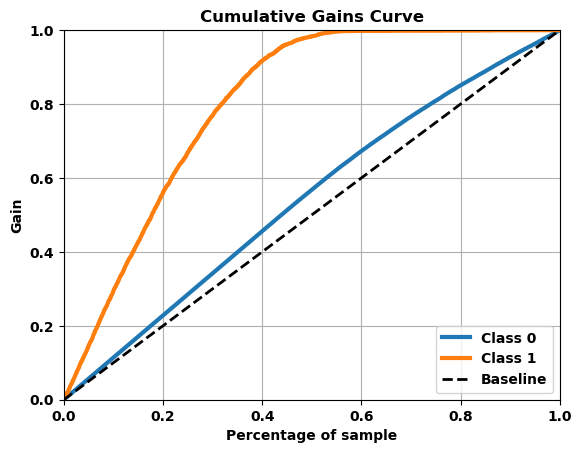

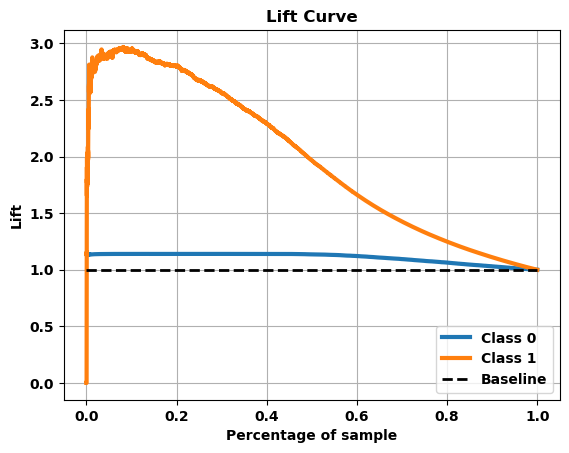

In [203]:
# model definition
lgbm_model_final = LGBMClassifier(verbose=0)

# model training
lgbm_model_final.fit( X, y )

# model prediction
yhat_lgbm_final = lgbm_model_final.predict_proba( x_test )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_test, yhat_lgbm_final );

#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_test, yhat_lgbm_final );

## 8.2 Performance Final Model Test

In [204]:
# copy dataframe
df9 = x_test.copy()
df9['response'] = y_test.copy()

# propensity score
df9['score'] = yhat_lgbm_final[:, 1].tolist()

# sort clients by propensity score
df9 = df9.sort_values( 'score', ascending=False )

# compute precision at k 
precision_at_lgbm = precision_at_k(df9, 0.2)
print('precision_at_k: {}'.format(precision_at_lgbm))

# compute recall at k
recall_at_lgbm = recall_at_k(df9, 0.2)
print('recall_at_k: {}'.format(recall_at_lgbm))

roc_auc_lgbm = roc_auc_score(y_test, yhat_lgbm_final[:,1])
print('ROC AUC Score: {}'.format(roc_auc_lgbm))

precision_at_k: 0.34566443657352747
recall_at_k: 0.5602806719115458
ROC AUC Score: 0.846343906850441


# 9.0. Deploy to Production

In [205]:
# Save trained model
pickle.dump( lgbm_model_final,open( 'C:/Users/rseme/Desktop/propensao-de-compra/src/model/lgbm_model.pkl', 'wb' ) )

## 9.1. Health Insurance Class

In [206]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsurance:
    
    def __init__( self ):
        self.home_path = 'C:/Users/rseme/Desktop/propensao-de-compra/'
        self.annual_premium_scaler =            pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler =                       pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) ) 
        self.vintage_scaler =                   pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) ) 
        self.target_encode_gender_scaler =      pickle.load( open( self.home_path + 'src/features/target_encode_gender_scaler.pkl', 'rb' ) )
        self.target_encode_region_code_scaler = pickle.load( open( self.home_path + 'src/features/target_encode_region_code_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler =   pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1. Rename Columns
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

        snakecase = lambda x: inflection.underscore (x)

        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new
        
        return df1 

    
    def feature_engineering( self, df2 ):
        # 2.0. Feature Engineering

        # Vehicle Damage Number
        df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # Vehicle Age
        df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )
        
        return df2
    
    
    def data_preparation( self, df5 ):
        # anual premium - StandarScaler
        df5['annual_premium'] = self.annual_premium_scaler.fit_transform( df5[['annual_premium']].values )

        # Age - MinMaxScaler
        df5['age'] = self.age_scaler.fit_transform( df5[['age']].values )

        # Vintage - MinMaxScaler
        df5['vintage'] = self.vintage_scaler.fit_transform( df5[['vintage']].values )

        # gender - One Hot Encoding / Target Encoding
        df5 = pd.get_dummies( df5, prefix='gender', columns=['gender'],dtype=int )

        # region_code - Target Encoding / Frequency Encoding
        target_encode_region_code = df5.groupby( 'region_code' ).size() / len(df5)
        df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

        # vehicle_age - One Hot Encoding / Frequency Encoding
        df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'], dtype=int)

        # policy_sales_channel - Target Encoding / Frequency Encoding
        fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
        df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
        
        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        
        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler

In [207]:
import pickle
import pandas as pd
from flask import Flask, request, Response
#from healthinsurance import HealthInsurance

# loading model
model = pickle.load( open( 'C:/Users/rseme/Desktop/propensao-de-compra/src/model/lgbm_model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.15.2:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

c:\Users\rseme\anaconda3\envs\propensao\lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 9.3. API Tester

In [208]:
import requests
import json

In [209]:
# loading test dataset
df_prod = pd.read_csv('data/test.csv')
#df_prod = df_prod.sample(1000)

#df_test = pd.read_csv('data/test.csv')
#df_test['response'] = y_test

In [210]:
df_prod


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.0,1,< 1 Year,No,30867.0,152.0,56
127033,508143,Female,38,1,28.0,0,1-2 Year,Yes,28700.0,122.0,165
127034,508144,Male,21,1,46.0,1,< 1 Year,No,29802.0,152.0,74
127035,508145,Male,71,1,28.0,1,1-2 Year,No,62875.0,26.0,265


In [211]:
# convert dataframe to json
data = json.dumps( df_prod.to_dict( orient='records' ) )

In [212]:
# API Call
url = 'http://127.0.0.1:5000/predict'
#url = 'https://health-insurance-model.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [213]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1 = d1[['id','prediction']]


In [214]:
df_final = pd.merge(df_prod, d1, on='id', how='left').sort_values('prediction', ascending=False).reset_index(drop=True)
df_final['prediction'] = df_final['prediction'].round(5)
df_final['ranking']=df_final.index+1
df_final

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,prediction,ranking
0,495527,Male,25,1,28.0,1,< 1 Year,No,31481.0,152.0,223,0.99180,1
1,498170,Female,27,1,10.0,1,< 1 Year,No,31311.0,152.0,258,0.96028,2
2,413506,Male,47,1,37.0,1,1-2 Year,No,28710.0,26.0,258,0.93890,3
3,441281,Male,44,1,50.0,1,1-2 Year,No,24513.0,25.0,258,0.92959,4
4,470986,Male,48,1,3.0,1,1-2 Year,No,24048.0,26.0,258,0.92176,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,435035,Female,23,1,28.0,1,< 1 Year,No,31924.0,152.0,247,0.00000,127033
127033,418088,Female,24,1,11.0,1,< 1 Year,No,41871.0,152.0,40,0.00000,127034
127034,407334,Male,21,1,41.0,1,< 1 Year,No,41885.0,152.0,24,0.00000,127035
127035,503203,Male,68,1,28.0,1,1-2 Year,No,38036.0,26.0,33,0.00000,127036
